
* Davidson R, Vachaspati P, Mirarab S, Warnow T. **Phylogenomic species tree estimation in the presence of incomplete lineage sorting and horizontal gene transfer.** _BMC Genomics._ 2015;16(Suppl 10):S1. doi:10.1186/1471-2164-16-S10-S1.

> The simulated dataset was simulated using SimPhy version 1.0 (downloaded January 20, 2015). There are 6 data sets containing 50 replicates apiece: each replicate has its own 51-taxon species tree. For every model species tree, one taxon is an outgroup, and so is actually a 50-taxon rooted species tree. These model trees were simulated under a Yule process, with birth rates set to 0.000001 (per generation) and the maximum tree length set to 2 million generations.
>
> Then, on each species tree, 1000 locus trees are simulated, where each can differ from the species tree due to HGT events, and we used HGT rates (1)-(6) given by $0$, $2 \times 10^{-9}$, $5 \times 10^{-9}$, $2 \times 10^{-8}$, $2 \times 10^{-7}$, and $5 \times 10^{-7}$. These values correspond to expected numbers of HGT events per gene of 0, 0.08, 0.2, 0.8, 8, and 20. Thus, HGT rate (1) is no HGT events, HGT rate (2) is 0.08 HGT events per gene, up to HGT rate (6) of 20 HGT events per gene. Note that in our simulations, for each HGT event, the probability of a branch being chosen as the receptor of the transfer is proportional to its distance from the donor.
>
> Once locus trees are simulated, a gene tree is simulated for each locus tree according to the MSC model, with population size parameter set to 200,000. Thus, at the end, we have 1000 true genes that differ from the species tree due to both ILS and also potentially HGT (when the HGT rate is positive).

In [159]:
%pylab inline
%load_ext rpy2.ipython
%config InlineBackend.figure_format='retina'
import pandas
import seaborn
import dendropy

Populating the interactive namespace from numpy and matplotlib
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [148]:
%%bash

rs=50                            # Number of species tree replicates
rl=U:1,1                         # Distribution of number of locus trees per species tree
rg=1                             # Number of gene trees per locus tree

cs=293745                        # Global options : Random number generator seed

sp=U:200000,2000000              # Species tree : Distribution of global population sizes
st=U:2000000,2000000             # Species tree : Distribution of maximum tree lengths
si=U:1,1                         # Species tree : Distribution of number of individuals per species
sl=U:50,50                       # Species tree : Distribution of number of species
sb=U:0.000001,0.0000001          # Species tree : Distribution of birth rates
so=U:1,0                         # Species tree : Simulate outgroup 
su=E:10000000                    # Species tree : Tree-wide substitution rate

hs=LN:1.5,1                      # Distribution of species-specific branch rate heterogeneity modifiers
hl=LN:1.5,1                      # Distribution of locus-specific rate heterogeneity modifiers
hg=LN:1.5,1                      # Distribution of gene-tree-branch-specific rate heterogeneity modifiers

od=0                             # SQLite database output
om=1                             # Tree mapping output

v=0                              # Verbosity

for HGT in {0.00000002,0.00005}; do
    for ILS in {0.000000001,0.00000005}; do
        
        lt=U:$HGT,$HGT           # Locus tree : Distribution of transfer rates
        lk=1                     # Locus tree : Transfers and gene conversions depend on tree distance
        
        ILS0=`echo $ILS \* 1.25 | bc -l`
        
        ld=U:$ILS,$ILS           # Locus tree : Distribution of loss rates (events/generation)
        lb=U:$ILS0,$ILS0         # Locus tree : Distribution of duplication rates (events/generation)
        lg=U:$ILS0,$ILS0         # Locus tree : Distribution of gene conversion rates (events/generation)
        
        o=simulations/model.$ILS.$HGT # Output prefix
        
        echo simulating with ILS=$ILS, ILS0=$ILS0, HGT=$HGT
    
        ./simphy -rs $rs -rl $rl -rg $rg -st $st -si $si -sl $sl \
                 -sb $sb -sp $sp -hs $hs -hl $hl -hg $hg -su $su \
                 -so $so -od $od -om $om -v $v -cs $cs -o $o     \
                 -ld $ld -lb $lb -lg $lg -lt $lt -lk $lk > /dev/null
    
    done
done

simulating with ILS=0.000000001, ILS0=.00000000125, HGT=0.00000002
simulating with ILS=0.00000005, ILS0=.0000000625, HGT=0.00000002
simulating with ILS=0.000000001, ILS0=.00000000125, HGT=0.00005
simulating with ILS=0.00000005, ILS0=.0000000625, HGT=0.00005


In [156]:
prefix = 'simulations/model.0.000000001.0.00000002/01/' #
prefix = 'simulations/model.0.000000001.0.00005/01/'

prefix = 'simulations/model.0.00000005.0.00000002/01/'
prefix = 'simulations/model.0.00000005.0.00005/01/'

t1 = dendropy.Tree.get_from_path( src = prefix + 's_tree.trees',
                                  schema = 'newick', preserve_underscores = True )

t2 = dendropy.Tree.get_from_path( src = prefix + 'g_trees1.trees',
                                  schema = 'newick', preserve_underscores = True )
# species_locusid_individualid
host_leafs =  [ leaf.taxon.label for leaf in t1.leaf_nodes() ]
guest_leafs = [ leaf.taxon.label for leaf in t2.leaf_nodes() ]

links = zeros( (len(host_leafs),len(guest_leafs)), dtype=int )

for i,leaf in enumerate( guest_leafs ) :
    j = host_leafs.index( leaf.split('_')[0] )
    links[j,i] = 1

pandas.DataFrame( links, index=host_leafs, columns=guest_leafs ).to_csv( prefix + 'links.csv' )

Rotating nodes to optimize matching...
Done.


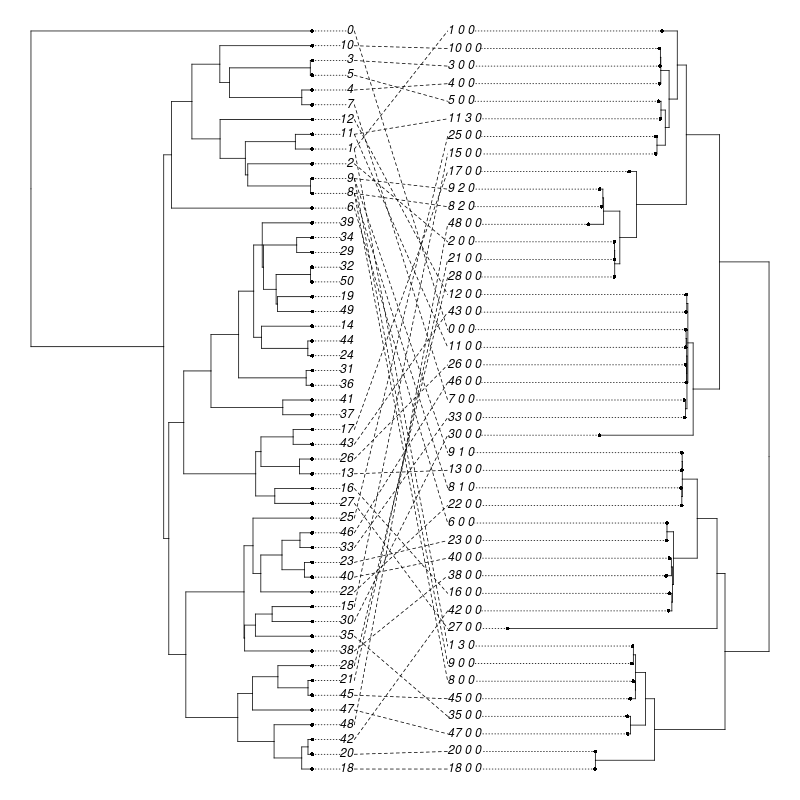

In [157]:
%%R -i prefix -w 800 -h 800 -u px

library("phytools")
library("igraph")

tr1   <- read.tree( paste( prefix, "s_tree.trees", sep="" ) )
tr2   <- read.tree( paste( prefix, "g_trees1.trees", sep="" ) )
links <- read.csv(  paste( prefix, "links.csv", sep="" ), 
                    row.names=1, stringsAsFactors = F, check.names = F )

im <- graph_from_incidence_matrix( as.matrix( links ) )
assoc <- as_edgelist( im )
obj <- cophylo( tr1, tr2, assoc=assoc )
#svg( outpath, width = 10, height = 12 )
plot( obj )

In [124]:
open( 'simulations/model.50.2000000.0.000001.0.000000000/01/g_trees0001.trees' ).read()

FileNotFoundError: [Errno 2] No such file or directory: 'simulations/model.50.2000000.0.000001.0.000000000/01/g_trees0001.trees'